In [3]:
import sys
sys.executable

'/Users/chantal/Desktop/systematic_review/abstract_env/bin/python'

In [4]:
import torch
from transformers import *
import logging
import matplotlib.pyplot as plt
import os
import re
from pprint import pprint
import pandas as pd
%matplotlib inline

### In this notebook, we're going to be extracting embeddings from a trained BERT model and visualizing them in different spaces

#### 1. Load text to be visualized

Here, we're going to use some keywords we automatically pulled out earlier for each topic, rather than visualizing random abstracts in full. 

NOTE: we can look at two different spaces: 
- where all systematic review topics are included --> this will show us whether we can build a generalizable model
- where one topic is visualized with a focus on the lable --> this will show us how separable and informative the embeddings are per label

Going to focus on the second bullet point. Also, as Delvin mentioned "[the second label would show] whether there are similarities in the representations learned by the model for each topic, and if it’s generalizable then those representations would be similar regardless of topic"

In [3]:
# read in each dataset into a dictionary
reviews = {}

# assuming naming follows 'type' + '_keywords.csv' structure 
for f in os.listdir('../data/keywords/'):
    if not f.startswith('.'):
        key = re.split(r'_', f)
        reviews[key[0]+'_'+key[1]] = f
        
PATH = os.path.abspath('../data/keywords/')

for key, dataset in reviews.items():
    reviews[key] = pd.read_csv(os.path.join(PATH, dataset), names='0', encoding='latin1')
    reviews[key] = sorted(set(str(reviews[key]['0']).split())) # removes duplicates 
    reviews[key] = [x for x in reviews[key] if x not in ['0,', 'Name:']]
    reviews[key] = ' '.join(reviews[key])

In [4]:
pprint(reviews)

{'ADIPP_0': 'acid adolescents adults aid alcohol also analysis anemia assess '
            'associate association attitude attitudes awareness base behavior '
            'birth blood bmi body boys breast breastfeed cancer care case '
            'cause change child children ci clinical collect common community '
            'compare concentrations conclusion conduct consumption control '
            'countries cross day days deficiency demographic determine develop '
            'development diabetes diagnosis diet dietary disease drink drug '
            'dtype: early eat education effect evidence experience exposure '
            'family feed female first focus follow food gestational girls '
            'growth high higher hiv hospital household human identify impact '
            'improve include income index infant infants infection information '
            'intake intervention interventions interview iodine iron kg '
            'knowledge life low mass maternal may mean measur

#### 2. Tokenize using BERT, obtain mappings of words to ids 

In [2]:
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = BertForSequenceClassification.from_pretrained('allenai/scibert_scivocab_uncased', 
                                                      output_hidden_states=True)

In [6]:
# encode keywords 
indexed_tokens = {}
segment_ids = {}

for key in reviews:
    indexed_tokens[key] = torch.Tensor(tokenizer.encode(reviews[key], add_special_tokens=True)).long().unsqueeze(0)
    segment_ids[key] = torch.Tensor([1]*len(indexed_tokens[key])).long().unsqueeze(0)

In [7]:
indexed_tokens['Scaling_0'].shape

torch.Size([1, 164])

In [8]:
# map ids to tokens 
id2token = {}
for key in indexed_tokens:
    for token in indexed_tokens[key]:
        id2token[key] = tokenizer.convert_ids_to_tokens(token)

#### 3. Run through BERT

In [9]:
# original saved file with DataParallel
state_dict = torch.load('/Users/chantal/Desktop/systematic_review/abstract_tool/_model/scibert_Scaling_data_3.pt',
                       map_location=torch.device('cpu'))

# create new OrderedDict that does not contain `module.`
from collections import OrderedDict

new_state_dict = OrderedDict()

for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
    
# load params
model.load_state_dict(new_state_dict) 
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [10]:
# testing with Scaling TODO: come back and do the rest
all_encoded_layers = {}
for key,data in indexed_tokens.items():
    with torch.no_grad():
        _, encoded_layers = model(data)
        all_encoded_layers[key] = encoded_layers
    _, encoded_layers_0 = model(indexed_tokens['Scaling_0'])
    _, encoded_layers_1 = model(indexed_tokens['Scaling_1'])

#### 4. Obtain hidden layers, stack them together

In [11]:
print ("Number of layers:", len(encoded_layers_0))
layer_i = 0

print ("Number of batches:", len(encoded_layers_0[layer_i]))
batch_i = 0

print ("Number of tokens:", len(encoded_layers_0[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(encoded_layers_0[layer_i][batch_i][token_i]))

Number of layers: 13
Number of batches: 1
Number of tokens: 164
Number of hidden units: 768


In [12]:
all_token_embeddings = {}

for key,layers in all_encoded_layers.items():
    token_embeddings = torch.stack(layers, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)

    # [# tokens, # layers, # features]
    token_embeddings = token_embeddings.permute(1,0,2)
    all_token_embeddings[key] = token_embeddings

In [13]:
label_0 = []
label_1 = []
for key,emb in all_token_embeddings.items():
    # print(key)
    if key.endswith('0'):
        label_0.append(emb)
    else:
        label_1.append(emb)
        
print(len(label_0), len(label_1))
# token_embeddings = torch.cat((token_embeddings_0, token_embeddings_1), dim=0)
# token_embeddings.size()

6 6


#### 5. Get the word embeddings by concatenating the last four layers but you can also combine them in different ways (e.g., summing)

In [14]:
token_vecs_cat = []

for token in token_embeddings: 
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    token_vecs_cat.append(cat_vec)

print (len(token_vecs_cat), len(token_vecs_cat[0]))

122 3072


In [15]:
token_vecs_sum_0 = []
token_vecs_sum_1 = []

for vec in label_0:
    for token in vec:
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum_0.append(sum_vec)

for vec in label_1:
    for token in vec:
        # print(token.shape)
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum_1.append(sum_vec)
        
print (len(token_vecs_sum_0), len(token_vecs_sum_0[0]))
print (len(token_vecs_sum_1), len(token_vecs_sum_1[0]))

956 768
779 768


#### 6. Project embeddings into space (e.g., using UMAP) 

In [16]:
# NOTE: This block of code is for tensorflow's projector..

# giant dimensions, use PCA to reduce

# from sklearn.decomposition import IncrementalPCA

# token_arr_0 = [t.numpy() for t in token_vecs_sum_0]


# ipca = IncrementalPCA(n_components=100, batch_size=100)
# ipca.fit(token_arr_0)
# x = ipca.transform(token_arr_0)

# np.savetxt('vecs_100_1.tsv', x[:50], delimiter='\\t', newline='\\n')

Notes about visualizing BERT embeddings. Words require context and will slightly alter the embedding depending on the sentence that's passed in.. could explore the same word in different sentences from the abstracts... 

- look at a plot of ALL keywords from ALL datasets split by 0/1 labels
- extract common words from 0/1 and plot their embeddings

(1735, 768)


/Users/chantal/Desktop/systematic_review/abstract_env/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11002. The TBB threading layer is disabled.
  warnings.warn(problem)


(1735, 2)


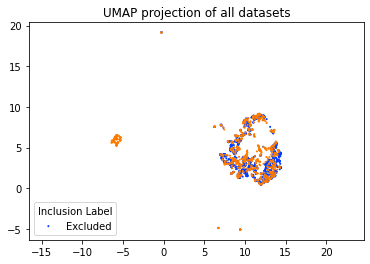

In [17]:
import numpy as np
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
import umap.umap_ as umap

token_arr_0 = [t.numpy() for t in token_vecs_sum_0]
token_arr_1 = [t.numpy() for t in token_vecs_sum_1]

token_arr = np.vstack((token_arr_0, token_arr_1))

print(token_arr.shape)

reducer = umap.UMAP()
embedding_ = reducer.fit_transform(token_arr)

print(embedding_.shape)

# note: comment and uncomment to get different plots for each label  
total = []
labels = {
    'ADIPP_0':    [0]*188,
    'VitaminD_0': [0]*99,
    'Rehab_0':    [0]*172,
    'NCDS_0':     [0]*172,
    'Scaling_0':  [0]*164,
    'Washing_0':  [0]*161,
    'ADIPP_1':    [1]*156,
    'VitaminD_1': [1]*139,
    'Rehab_1':    [1]*133,
    'NCDS_1':     [1]*118,
    'Scaling_1':  [1]*111,
    'Washing_1':  [1]*122,
    
}

for key,lab in labels.items():
    total.extend(lab)


fig, ax = plt.subplots()
scatter = ax.scatter(embedding_[:, 0], embedding_[:, 1], c=[sns.color_palette("bright", 2)[x] for x in total],
                     s=1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of all datasets', fontsize=12)
legend_curve = ax.legend(labels = ['Excluded','Included'],
                         loc="lower left",title="Inclusion Label", shadow=False)

# More visualizations:

- In the last section, we were mapping the top n keywords for each label. Now, we want to visualize the [CLS] (aka aggregate) vector for each _abstract_ within each label. 
- Instead of colouring by label, we're going to extract and colour by time-bins from the original data.. this will potentially show us any underlying time biases
- From this, we can explore whether the time bias is correlated with the labels

1. load abstracts for each label 

In [3]:
reviews = {}

for f in os.listdir('/Users/chantal/Desktop/systematic_review/abstract_tool/_initial_work/cleaned_data_date/'):
    if not f.startswith('.') and f.endswith('.tsv'):
        key = re.split(r'_', f)
        reviews[key[0]+'_'+key[1]] = f
        
PATH = os.path.abspath('/Users/chantal/Desktop/systematic_review/abstract_tool/_initial_work/cleaned_data_date/')

for key, dataset in reviews.items():
    reviews[key] = pd.read_csv(os.path.join(PATH, dataset), 
                               sep='\t', 
                               header=None, 
                               names=['idx', 'abstract', 'time', 'label'],
                               encoding='latin1')
    
print(reviews.keys())

dict_keys(['Scaling_data.tsv', 'NCDS_data.tsv', 'ADIPP_data.tsv', 'WASH_data.tsv', 'Rehab_data.tsv', 'VitaminD_data.tsv'])


In [4]:
# prep to pass into BERT 

scaling = reviews['Scaling_data.tsv']['abstract'].tolist()
scaling_labels = reviews['Scaling_data.tsv']['time'].tolist()

ncds = reviews['NCDS_data.tsv']['abstract'].tolist()
ncds_labels = reviews['NCDS_data.tsv']['time'].tolist()

adipp = reviews['ADIPP_data.tsv']['abstract'].tolist()
adipp_labels = reviews['ADIPP_data.tsv']['time'].tolist()

wash = reviews['WASH_data.tsv']['abstract'].tolist()
wash_labels = reviews['WASH_data.tsv']['time'].tolist()

rehab = reviews['Rehab_data.tsv']['abstract'].tolist()
rehab_labels = reviews['Rehab_data.tsv']['time'].tolist()

vitamind = reviews['VitaminD_data.tsv']['abstract'].tolist()
vitamind_labels = reviews['VitaminD_data.tsv']['time'].tolist()

In [8]:
# note; my laptop can't handle all the abstracts..
NUM_ABSTRACTS = 1000

2. Send abstracts through BERT, get the pooled output 

In [9]:
indexed_tokens = {}
segment_ids = {}
    
# start with scaling 

for idx, ab in enumerate(scaling[:NUM_ABSTRACTS]):
    indexed_tokens[idx] = torch.Tensor(tokenizer.encode(str(ab), add_special_tokens=True, max_length=511)).long().unsqueeze(0)
    segment_ids[idx] = torch.Tensor([1]*len(indexed_tokens[idx])).long().unsqueeze(0)
    
# map ids to tokens 
id2token = {}
for key in indexed_tokens:
    for token in indexed_tokens[key]:
        id2token[key] = tokenizer.convert_ids_to_tokens(token)
        
all_encoded_layers = {}
for key,data in indexed_tokens.items():
    with torch.no_grad():
        _, encoded_layers = model(data)
        all_encoded_layers[key] = encoded_layers

In [ ]:
all_CLS_embeddings = {} 

for key,layers in all_encoded_layers.items():
        token_embeddings = torch.stack(layers, dim=0)
        token_embeddings = torch.squeeze(token_embeddings, dim=1)

        # [# tokens, # layers, # features]
        token_embeddings = token_embeddings.permute(1,0,2)
        all_CLS_embeddings[key] = token_embeddings[0]
        # print(token_embeddings[0].unsqueeze(0).shape)
    
token_vecs_sum = []

for key,vec in all_CLS_embeddings.items():
    sum_vec = torch.sum(vec[-4:], dim=0)
    token_vecs_sum.append(sum_vec)

print(len(token_vecs_sum))

In [5]:
print(len(token_vecs_sum))

NameError: name 'token_vecs_sum' is not defined

(150, 2)


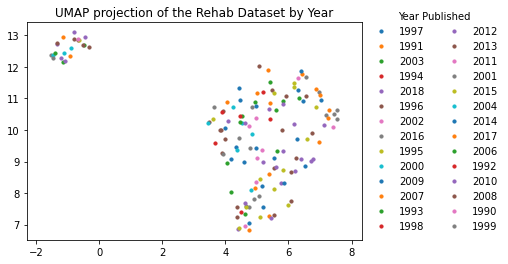

In [45]:
import numpy as np
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
import umap.umap_ as umap
from collections import defaultdict


token_arr = [t.numpy() for t in token_vecs_sum]

reducer = umap.UMAP()
embedding_ = reducer.fit_transform(token_arr)

print(embedding_.shape)

labels = rehab_labels[:NUM_ABSTRACTS]

label_dict = defaultdict(list)

for embedding, year in zip(embedding_, labels):
    label_dict[year].append(embedding)
    
    
unique = set(labels)

colours = sns.color_palette(n_colors=len(unique))

fig, ax = plt.subplots()

for year,c in zip(unique,colours):
    x = np.asarray(label_dict[year])[:, 0]
    y = np.asarray(label_dict[year])[:, 1]
    ax.scatter(x,
               y, 
               s=10, 
               label=labels,
               alpha=1, 
               )

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Rehab Dataset by Year', fontsize=12)
legend_curve = ax.legend(labels=unique,
                         frameon=False,
                         loc="lower left",
                         title="Year Published", 
                         shadow=False,
                         bbox_to_anchor=(1, 0),
                         ncol=2)

plt.show()
